# Import libraries and metrics

In [1456]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import re

ROOT_RESULTS_PATH = "results/"
RESULTS_PATH = "results/5000c_16.0e_s/"
CLIENTS_METRICS = "clients.json"

PLOTS_OUT_PATH = "plots/"

with open(RESULTS_PATH + CLIENTS_METRICS, "r") as f:
    clients_metrics = list(map(lambda x: json.loads(x), f.readlines()))


# Results

### Poll Values

In [1457]:
poll_values = dict()
poll_values["D01"] = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
poll_values["D02"] = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
poll_values["N01"] = 0.0, 10.0
poll_values["N02"] = 0.0, 10.0

# create dict pollId -> description
descriptions = dict()
for r in clients_metrics:
    if r["metric"] == "poll_create":
        descriptions[r["pollId"]] = r["description"]

## Basic Stats

In [1458]:
def diff_values_discrete(description: str):
    # get times true vote differs from noisy vote
    return sum(list(map(lambda r: 0 if int(r["trueVoteValue"]) - int(r["noisyVoteValue"]) == 0 else 1,
                    filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def diff_values_numeric(description: str):
    # get times true vote differs from noisy vote
    return sum(list(map(lambda r: abs(float(r["trueVoteValue"]) - float(r["noisyVoteValue"])),
                    filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def diff_percentile95_numeric(description: str):
    # get times true vote differs from noisy vote
    return np.percentile(list(map(lambda r: abs(float(r["trueVoteValue"]) - float(r["noisyVoteValue"])),
                    filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))), 95)

def epsilon(description: str):
    return float(list(map(lambda r: r["epsilon"],filter(lambda r: r["metric"] == "poll_create" and r["description"] == description, clients_metrics)))[0])

def prob_truth(epsilon: float):
    return np.exp(epsilon) / (np.exp(epsilon) + 1)

def means_numeric(description: str):
    # mean of both true and noisy votes
    return np.mean(list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))), np.mean(list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics))))

def num_votes(description):
    return int(list(map(lambda r: r["numVotes"],filter(lambda r: r["metric"] == "poll_complete" and descriptions[r["pollId"]]  == description, clients_metrics)))[0])

In [1459]:
print("Epsilon [D01]: ", epsilon("D01"))
print("Epsilon [D02]: ", epsilon("D02"))

print("Epsilon [N01]: ", epsilon("N01"))
print("Epsilon [N02]: ", epsilon("N02"))

Epsilon [D01]:  16.0
Epsilon [D02]:  16.0
Epsilon [N01]:  16.0
Epsilon [N02]:  16.0


In [1460]:
print("P(Truth) [D01]: ", prob_truth(epsilon("D01")))
print("P(Truth) [D02]: ", prob_truth(epsilon("D02")))

P(Truth) [D01]:  0.9999998874648379
P(Truth) [D02]:  0.9999998874648379


In [1461]:
print("Num. false votes [D01]: ", diff_values_discrete("D01"))
print("Num. false votes [D02]: ", diff_values_discrete("D02"))

Num. false votes [D01]:  0
Num. false votes [D02]:  0


In [1462]:
avg_n01 = diff_values_numeric("N01") / num_votes("N01")
avg_n02 = diff_values_numeric("N02") / num_votes("N02")
print("Avg noise diff [N01]: ", avg_n01)
print("Avg noise diff [N02]: ", avg_n02)
# percentile 95%
print("95% percentile [N01]: ", diff_percentile95_numeric("N01"))
print("95% percentile [N02]: ", diff_percentile95_numeric("N02"))

Avg noise diff [N01]:  0.6228587383547443
Avg noise diff [N02]:  0.5690576427045857
95% percentile [N01]:  1.8710871482765337
95% percentile [N02]:  1.649677104550506


In [1463]:
#print("Means (true, noisy) [N01]: ", means_numeric("N01"))
print("Mean diff [N01]: ", means_numeric("N01")[0] - means_numeric("N01")[1])
#print("Means (true, noisy) [N02]: ", means_numeric("N02"))
print("Mean diff [N02]: ", means_numeric("N02")[0] - means_numeric("N02")[1])

Mean diff [N01]:  -0.002865743068337423
Mean diff [N02]:  0.09145094879228122


## Distribution Comparison

In [1487]:
def calculate_discrete_vote_distribution(description: str, nvalues: int):
    # Get the number of votes for each value
    votes = list(map(lambda r: int(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    noisy_votes = list(map(lambda r: int(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    # Calculate the distribution
    return np.array([votes.count(value) for value in range(nvalues+1)]), np.array([noisy_votes.count(value) for value in range(nvalues+1)])

def calculate_discrete_vote_distribution_e(description: str, nvalues: int, metrics):
    descrs = dict()
    for r in metrics:
        if r["metric"] == "poll_create":
            descrs[r["pollId"]] = r["description"]

    # Get the number of votes for each value
    votes = list(map(lambda r: int(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descrs[r["pollId"]] == description, metrics)))
    noisy_votes = list(map(lambda r: int(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descrs[r["pollId"]] == description, metrics)))
    # Calculate the distribution
    return np.array([votes.count(value) for value in range(nvalues+1)]), np.array([noisy_votes.count(value) for value in range(nvalues+1)])

def calculate_numeric_vote_distribution(description: str):
    # Get the number of votes for each value
    votes = list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    noisy_votes = list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descriptions[r["pollId"]] == description, clients_metrics)))
    # Calculate the distribution
    return np.array(votes), np.array(noisy_votes)

def calculate_numeric_vote_distribution_e(description: str, metrics):
    descrs = dict()
    for r in metrics:
        if r["metric"] == "poll_create":
            descrs[r["pollId"]] = r["description"]

    # Get the number of votes for each value
    votes = list(map(lambda r: float(r["trueVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descrs[r["pollId"]] == description, metrics)))
    noisy_votes = list(map(lambda r: float(r["noisyVoteValue"]),filter(lambda r: r["metric"] == "poll_vote" and descrs[r["pollId"]] == description, metrics)))
    # Calculate the distribution
    return np.array(votes), np.array(noisy_votes)

def count_ranges(values, nranges: int, min_val: float, max_val: float):
    # Calculate the size of each range interval
    interval_size = (max_val - min_val) / nranges

    # Initialize the count for each range interval
    counts = [0] * nranges

    # Iterate over the values and count the number of values in each range interval
    for value in values:
        # Adjust value if it falls outside the specified range
        if value < min_val:
            index = 0
        elif value > max_val:
            index = nranges - 1
        else:
            # Determine the index of the range interval where the value falls
            index = int((value - min_val) // interval_size)

        counts[index] += 1

    return counts

def calculate_values_integer_uniform(a: int, b: int, nsamples: int):
    x = np.arange(a, b+1)
    distributions_probs = np.array([round((1 / (b - a + 1)) * nsamples) for _ in x])
    # Calculate the cumulative sum of probabilities
    cumulative_probs = np.cumsum(distributions_probs)
    # Round the probabilities while ensuring they sum up to the desired number of samples
    rounded_probs = np.round(cumulative_probs / cumulative_probs[-1] * nsamples).astype(int)
    rounded_probs[1:] -= rounded_probs[:-1].copy()
    return rounded_probs

def calculate_values_binomial(n: int, p: float, nsamples: int):
    x = np.arange(n+1)
    distributions_probs = np.array([round(np.math.comb(n, k) * p**k * (1-p)**(n-k) * nsamples) for k in x])
    # Calculate the cumulative sum of probabilities
    cumulative_probs = np.cumsum(distributions_probs)
    # Round the probabilities while ensuring they sum up to the desired number of samples
    rounded_probs = np.round(cumulative_probs / cumulative_probs[-1] * nsamples).astype(int)
    rounded_probs[1:] -= rounded_probs[:-1].copy()
    return rounded_probs

def calculate_values_normal(mean: float, std: float, nsamples: int):
    return np.linspace(mean - 4*std, mean + 4*std, nsamples)

def gen_bars_discrete_poll(description: str, expected_distribution: np.array, true_distribution: np.array, noisy_distribution: np.array):
    bar_width = 0.2
    #print(expected_distribution)
    print(true_distribution)
    print(noisy_distribution)

    x_labels = poll_values[description]
    x = np.arange(len(x_labels))

    #plt.bar(x, expected_distribution, width=bar_width, label="Expected Vote Distribution")
    plt.bar(x + bar_width, true_distribution, width=bar_width, label="True Votes")
    plt.bar(x + 2*bar_width, noisy_distribution, width=bar_width, label="DP Votes (ε = {})".format(epsilon(description)))
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Votes")
    plt.xticks(x + bar_width, x_labels)
    plt.ylabel('Nº Votes')
    plt.gca().get_yaxis().set_major_locator(plt.MaxNLocator(integer=True))
    # toggle grid line in y axin in background
    plt.grid(axis='y')
    plt.gca().set_axisbelow(True)
    plt.savefig(PLOTS_OUT_PATH + "discrete_{}_{}e.pdf".format(description, epsilon(description)))
    plt.show()

def gen_plot_numeric_poll(description: str, nranges: int, mean: float, std: float):
    min_val = poll_values[description][0]
    max_val = poll_values[description][1]

    nvotes = num_votes(description)

    #expected_distribution = count_ranges(calculate_values_normal(mean, std, nvotes), nranges, min_val, max_val)
    true_values, noisy_values = calculate_numeric_vote_distribution(description)
    true_distribution = count_ranges(true_values, nranges, min_val, max_val)
    noisy_distribution = count_ranges(noisy_values, nranges, min_val, max_val)
    # x should be beggining of each range
    x = np.arange(min_val, max_val, (max_val-min_val)/nranges)
    #plt.plot(x, expected_distribution, label="Expected Vote Distribution")
    plt.plot(x, true_distribution, label="True Votes")
    plt.plot(x, noisy_distribution, label="DP Votes (ε = {})".format(epsilon(description)))

    plt.xlim(min_val, max_val)
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Votes")
    plt.ylabel('Nº Votes')
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.savefig(PLOTS_OUT_PATH + "numeric_{}_{}e.pdf".format(description, epsilon(description)))
    plt.show()

def gen_multibars_discrete_poll():
    epsilons = [0.25, 0.5, 1.0, 2.0]
    clients_metrics_e = dict()

    for exp in os.listdir(ROOT_RESULTS_PATH):
        # use regex to get epsilon: format 5000c_0.25e_s
        ep = float(re.search(r'(\d+c)_(\d+\.\d+)e', exp).group(2))
        if ep not in epsilons:
            continue
        with open(ROOT_RESULTS_PATH + exp + "/" + CLIENTS_METRICS, "r") as f:
            clients_metrics_e[ep] = list(map(lambda x: json.loads(x), f.readlines()))

    for description in list(filter(lambda x: x.startswith("D"), poll_values.keys())):
        x_labels = poll_values[description]
        x = np.arange(len(x_labels))
        bar_width = 0.15
        fig, ax = plt.subplots()

        for i in range(len(epsilons)):
            ep = epsilons[i]
            true_distribution, noisy_distribution = calculate_discrete_vote_distribution_e(description, len(x_labels) - 1, clients_metrics_e[ep])
            ax.bar((x + i*bar_width), noisy_distribution, width=bar_width, label="DP Votes (ε = {})".format(ep))
        ax.bar(x - bar_width, true_distribution, width=bar_width, label="True Votes")
        ax.legend()
        ax.set_xlabel("Votes")
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel('Nº Votes')
        ax.grid(axis='y')
        ax.set_axisbelow(True)
        plt.tight_layout()
        plt.savefig(PLOTS_OUT_PATH + "discrete_{}_multibar.pdf".format(description))
        plt.show()

def gen_multilines_numeric_poll():
    epsilons = [0.25, 0.5, 1.0, 2.0,4.0,8.0,12.0,16.0,20.0]
    clients_metrics_e = dict()

    for exp in os.listdir(ROOT_RESULTS_PATH):
        # use regex to get epsilon: format 5000c_0.25e_s
        ep = float(re.search(r'(\d+c)_(\d+\.\d+)e', exp).group(2))
        if ep not in epsilons:
            continue
        with open(ROOT_RESULTS_PATH + exp + "/" + CLIENTS_METRICS, "r") as f:
            clients_metrics_e[ep] = list(map(lambda x: json.loads(x), f.readlines()))

    nranges = 20
    for description in list(filter(lambda x: x.startswith("N"), poll_values.keys())):
        min_val = poll_values[description][0]
        max_val = poll_values[description][1]

        fig, ax = plt.subplots()

        true_values, noisy_values = calculate_numeric_vote_distribution(description)
        true_distribution = count_ranges(true_values, nranges, min_val, max_val)
        noisy_distribution = count_ranges(noisy_values, nranges, min_val, max_val)
        # x should be beggining of each range
        x = np.arange(min_val, max_val, (max_val-min_val)/nranges)

        for ep in epsilons:
            true_values, noisy_values = calculate_numeric_vote_distribution_e(description, clients_metrics_e[ep])
            noisy_distribution = count_ranges(noisy_values, nranges, min_val, max_val)
            ax.plot(x, noisy_distribution, label="DP Votes (ε = {})".format(ep))
        true_distribution = count_ranges(true_values, nranges, min_val, max_val)
        ax.plot(x, true_distribution, label="True Votes")

        plt.xlim(min_val, max_val)
        ax.legend()
        plt.tight_layout()
        plt.xlabel("Votes")
        plt.ylabel('Nº Votes')
        plt.grid()
        ax.set_axisbelow(True)
        plt.tight_layout()
        plt.savefig(PLOTS_OUT_PATH + "numeric_{}_multiline.pdf".format(description))
        plt.show()



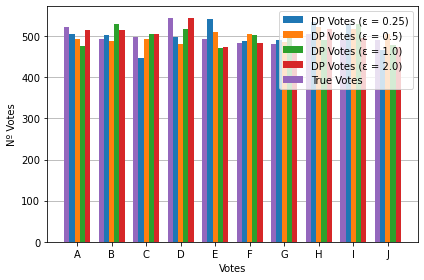

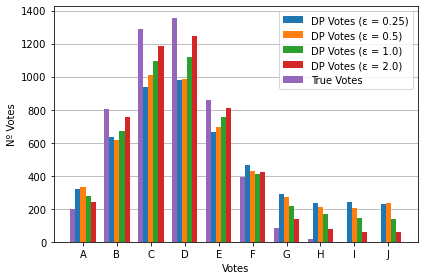

In [1472]:
gen_multibars_discrete_poll()

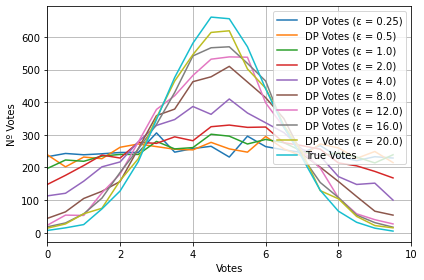

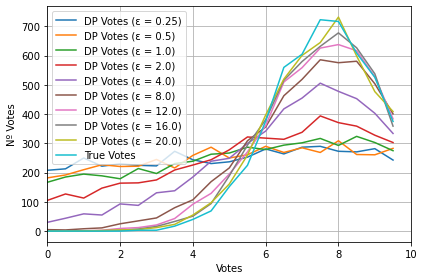

In [1488]:
gen_multilines_numeric_poll()

### D01 Poll

In [ ]:

a = 0
b = 9

description = "D01"
nvotes = num_votes(description)

expected_distribution = calculate_values_integer_uniform(a, b, nvotes)
true_distribution, noisy_distribution = calculate_discrete_vote_distribution(description, b)

gen_bars_discrete_poll(description, expected_distribution, true_distribution, noisy_distribution)

### D02 Poll

In [ ]:

# Set the parameters for the binomial distribution
n = 9  # Number of trials
p = 0.3  # Probability of success

description = "D02"
nvotes = num_votes(description)

expected_distribution = calculate_values_binomial(n, p, nvotes)
true_distribution, noisy_distribution = calculate_discrete_vote_distribution(description, n)

gen_bars_discrete_poll(description, expected_distribution, true_distribution, noisy_distribution)

In [ ]:
nranges = 50

### N01 Poll

In [ ]:
description = "N01"
mean = 5.0
std = 1.5

gen_plot_numeric_poll(description, nranges, mean, std)


### N02 Poll

In [ ]:
description = "N02"
mean = 8.0
std = 1.5

gen_plot_numeric_poll(description, nranges, mean, std)
